In [7]:
import numpy as np

In [8]:
class Team():

  def __init__(self, mu=1, var=1, name=None):
    self.mu = mu        # Mean skill.
    self.var = var      # Variance of skill.
    self.name = name    # Name of the team.

  def get_mu(self):
    return self.mu

  def get_var(self):
    return self.var

  def get_name(self):
    return self.name

  def set_mu(self, new_mu):
    self.mu = new_mu

  def set_var(self, new_var):
    self.var = new_var

  def set_name(self, new_name):
    self.name = new_name

  def __repr__(self):
    return "{}: mu={}, var={}".format(self.name,
                                       self.mu,
                                       self.var)

![Bayesian  Network](./images/factor_graph_bg.png)

In [9]:
import scipy.stats as stats
class Message():

    def __init__(self, mean, var):
        self.mean = mean
        self.var = var

    def truncMM(self, y):
        if y==1:
            a = 0
            b = np.inf
        else:
            a = -np.inf
            b = 0
        a_s, b_s = (a - self.mean)/np.sqrt(self.var), (b - self.mean)/np.sqrt(self.var)
        m = stats.truncnorm(a_s, b_s, loc=self.mean, scale=np.sqrt(self.var)).mean()
        v = stats.truncnorm(a_s, b_s, loc=self.mean, scale=np.sqrt(self.var)).var()
        return Message(m, v)

    def multiply(self, mu):
        mp = (self.mean*mu.var + mu.mean*self.var)/(mu.var + self.var)
        vp = mu.var*self.var/(mu.var + self.var)
        return Message(mp, vp)

    def divide(self, mu):
        mf = (self.mean*mu.var - mu.mean*self.var)/(mu.var - self.var)
        vf = mu.var*self.var/(mu.var - self.var)
        return Message(mf, vf)

    def __repr__(self):
        return 'mean:{}, var:{}'.format(self.mean,
                                        self.var)


$\huge \mu_{6} = \sum_{y \in \{-1,1\}} \mu_{7}f_{4}(t,y)$ <br>
$\huge \mu_{6} = \sum_{y \in \{-1,1\}} I(y=\hat{y})I(y=SIGN(t))$ <br>
$\huge \mu_{6} = I(\hat{y} = SIGN(t)) = \Big\{ ^{I(t>0), \hat{y} = 1} _{I(t \leq 0), \hat{y} = -1} $



$\mu_{3} = \mu_{1} = f_{1}(s_{1}) \quad$    and    $\quad \mu_{4} = \mu_{2} = f_{2}(s_{2})$ <br>

$\huge \mu_{5} \int \int^{\infty}_{-\infty} \mu_{3}\mu_{4}f_{3}(s_{1}, s_{2}, t) ds_{1}, ds_{2}$ <br>
$\huge = N(t;m_{1}- m_{2}, \sigma_{1}²+\sigma_{2}²+\sigma_{t}²)$ <br>
Independence: $p(s_{1},s_{2}) = p(s_{1})p(s_{2})$

$\huge p(t|y) = \mu_{5}\mu_{6} = \Big\{ ^{I(t>0) N(t;m_{1}- m_{2}, \sigma_{1}²+\sigma_{2}²+\sigma_{t}²)} _{I(t \leq 0)N(t;m_{1}- m_{2}, \sigma_{1}²+\sigma_{2}²+\sigma_{t}²)} $ <br>
Two truncated gaussians

Aproximate the truncated gaussian with moment matching
$\hat{p}(t|y) = N(t;m_*,\sigma²_*)$

$\huge \mu_{9} = \frac{\hat{p}(t|y)}{\mu_{5}} = N(t;m_{9}, \sigma_{9}²)$ <br>
$\huge m_{9} = \frac{\sigma_*²(m_1 - m_2) - m_* (\sigma_1² + \sigma_2² + \sigma_t²)}{\sigma_1² + \sigma_2² + \sigma_t² - \sigma_*²}$ <br>
$\huge \sigma_9² = \frac{\sigma_*² (\sigma_1² + \sigma_2² + \sigma_t²)}{\sigma_1² + \sigma_2² + \sigma_t² - \sigma_*²}$

$\huge \mu_{10} = \int \int_{-\infty}^{\infty} \mu_{9}f_3(s_1,s_2,t)f_2(s_2)dtds_2$ <br>
$\huge \mu_{10} = \int \int_{-\infty}^{\infty} \mu_{9}N(t;s_1 - s_2, \sigma_t²)N(s_2;m_2,\sigma_2²)dtds_2$ <br>
$\huge \mu_{10} = \int_{-\infty}^{\infty}\mu_9 N(t;s_1 - m_2, \sigma_t² + \sigma_2²) dt$ <br>
$\huge \mu_{10} = N(s_1;m_{10}, \sigma_{10}²)$ <br>
$\huge m_{10} = m_9 - m_2$ <br>
$\huge \sigma_{10}² = \sigma_t² + \sigma_2² + \sigma_9²$

$\huge \mu_{11} = N(s_2;m_{11}, \sigma_{11}²)$ <br>
$\huge m_{11} = m_1 - m_9$ <br>
$\huge \sigma_{11}² = \sigma_t² + \sigma_1² + \sigma_9²$

The marginal densities of $s_1$ and $s_2$: <br>
$\huge p(s_1|y) = f_1(s_1)\mu_{10} = N(s_1; \frac{m_1\sigma_{10}² + m_{10}\sigma_1²}{\sigma_{10}²+\sigma_1²}, \frac{ \sigma_{10}²\sigma_1² }{ \sigma_{10}² + \sigma_1² })$ <br>
$\huge p(s_2|y) = f_2(s_2)\mu_{11} = N(s_2; \frac{m_2\sigma_{11}² + m_{11}\sigma_2²}{\sigma_{11}²+\sigma_2²}, \frac{ \sigma_{11}²\sigma_2² }{ \sigma_{11}² + \sigma_2² })$

In [10]:
def update_skills_MP(t1, t2, var_t, y_obs):
    mu1 = Message(t1.mu, t1.var)
    mu2 = Message(t2.mu, t2.var)
    mu3 = mu1
    mu4 = mu2
    mu5 = Message(t1.mu - t2.mu, t1.var + t2.var + var_t)
    marginal_t = mu5.truncMM(y_obs)
    mu9 = marginal_t.divide(mu5)
    mu10 = Message(mu9.mean + mu2.mean, var_t + mu2.var + mu9.var)
    mu11 = Message(mu1.mean - mu9.mean, var_t + mu1.var + mu9.var)
    marginal_s1 = mu10.multiply(mu1)
    marginal_s2 = mu11.multiply(mu2)
    t1.set_mu(marginal_s1.mean)
    t1.set_var(marginal_s1.var)
    t2.set_mu(marginal_s2.mean)
    t2.set_var(marginal_s2.var)

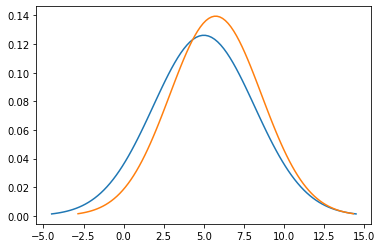

In [13]:
import matplotlib.pyplot as plt
import math 

team1 = Team(5, 10, 'team1')
team2 = Team(1, 10, 'team2')
team3 = Team(5, 10, 'team3')
team4 = Team(1, 10, 'team4')

sigma = math.sqrt(team1.var)
x = np.linspace(team1.mu - 3*sigma, team1.mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, team1.mu, sigma))

var_t = 3
y_obs = 1

update_skills_MP(team1, team2, var_t, y_obs)

sigma = math.sqrt(team1.var)
x = np.linspace(team1.mu - 3*sigma, team1.mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, team1.mu, sigma))